Chelsea Watterworth-Analysis 1

Begin by importing libraries

import numpy as np
import pandas as pd
from itertools import product
import copy


def create_parameter_grid(scenario_inputs):
    """Create list of dictionaries, each of which corresponds to a set of variable values for a scenario.

    Parameters
    ----------
    scenario_inputs : dict of str to sequence
            Keys are input variable names and values are sequence of values for each scenario for this variable.

    Returns
    -------
    List of dictionaries
    """
    param_grid = []

    keys, values = zip(*scenario_inputs.items())

    for v in product(*values):
        params = dict(zip(keys, v))
        param_grid.append(params)

    return param_grid


def get_sim_results_df(results):
    """Transform raw simulation output dictionary to Pandas ``DataFrame``.

    Parameters
    ----------
    results : list of dictionaries

    Returns
    -------
    Pandas DataFrame
    """
    dfs = []
    for r in results:
        df = pd.DataFrame(r['output'])
        df['scenario_num'] = r['scenario_num']
        for key, val in r['scenario_vals'].items():
            df[key] = val

        dfs.append(df)

    if len(dfs) > 1:
        results_df = pd.concat(dfs)
        return results_df
    else:
        return dfs[0]


class Model():
    """Base class for models"""

    def update(self, param_dict):
        """Update parameter values

        """

        for key in param_dict:
            setattr(self, key, param_dict[key])

    def data_table(self, scenario_inputs, outputs):
        """Create n-inputs by m-outputs data table.

        Parameters
        ----------
        scenario_inputs : dict of str to sequence
            Keys are input variable names and values are sequence of values for each scenario for this variable.

        outputs : list of str
            List of output variable names

        Returns
        -------
        results_df : pandas DataFrame
            Contains values of all outputs for every combination of scenario inputs
        """

        # Clone the model using deepcopy
        model_clone = copy.deepcopy(self)

        # Create parameter grid
        dt_param_grid = list(create_parameter_grid(scenario_inputs))

        # Create the table as a list of dictionaries
        results = []

        # Loop over the scenarios
        for params in dt_param_grid:
            # Update the model clone with scenario specific values
            model_clone.update(params)
            # Create a result dictionary based on a copy of the scenario inputs
            result = copy.copy(params)
            # Loop over the list of requested outputs
            for output in outputs:
                # Compute the output.
                out_val = getattr(model_clone, output)()
                # Add the output to the result dictionary
                result[output] = out_val

            # Append the result dictionary to the results list
            results.append(result)

        # Convert the results list (of dictionaries) to a pandas DataFrame and return it
        results_df = pd.DataFrame(results)
        return results_df

    def goal_seek(self, obj_fn, target, by_changing, a, b, N=100):
        """Approximate solution of f(x)=0 on interval [a,b] by bisection method.

        Parameters
        ----------
        obj_fn : str
            The function name for which we are trying to approximate a solution f(x)=target.
        target : float
            The goal
        by_changing : str
            Name of the input variable in model
        a,b : numbers
            The interval in which to search for a solution. The function returns
            None if (f(a) - target) * (f(b) - target) >= 0 since a solution is not guaranteed.
        N : (positive) integer
            The number of iterations to implement.

        Returns
        -------
        x_N : number
            The midpoint of the Nth interval computed by the bisection method. The
            initial interval [a_0,b_0] is given by [a,b]. If f(m_n) - target == 0 for some
            midpoint m_n = (a_n + b_n)/2, then the function returns this solution.
            If all signs of values f(a_n), f(b_n) and f(m_n) are the same at any
            iteration, the bisection method fails and return None.
        """
        # TODO: Checking of inputs and outputs

        # Clone the model
        model_clone = copy.deepcopy(self)

        # The following bisection search is a direct adaptation of
        # https://www.math.ubc.ca/~pwalls/math-python/roots-optimization/bisection/
        # The changes include needing to use an object method instead of a global function
        # and the inclusion of a non-zero target value.

        setattr(model_clone, by_changing, a)
        f_a_0 = getattr(model_clone, obj_fn)()
        setattr(model_clone, by_changing, b)
        f_b_0 = getattr(model_clone, obj_fn)()

        if (f_a_0 - target) * (f_b_0 - target) >= 0:
            # print("Bisection method fails.")
            return None

        # Initialize the end points
        a_n = a
        b_n = b
        for n in range(1, N + 1):
            # Compute the midpoint
            m_n = (a_n + b_n) / 2

            # Function value at midpoint
            setattr(model_clone, by_changing, m_n)
            f_m_n = getattr(model_clone, obj_fn)()

            # Function value at a_n
            setattr(model_clone, by_changing, a_n)
            f_a_n = getattr(model_clone, obj_fn)()

            # Function value at b_n
            setattr(model_clone, by_changing, b_n)
            f_b_n = getattr(model_clone, obj_fn)()

            # Figure out which half the root is in, or if we hit it exactly, or if the search failed
            if (f_a_n - target) * (f_m_n - target) < 0:
                a_n = a_n
                b_n = m_n
            elif (f_b_n - target) * (f_m_n - target) < 0:
                a_n = m_n
                b_n = b_n
            elif f_m_n == target:
                # print("Found exact solution.")
                return m_n
            else:
                # print("Bisection method fails.")
                return None

        # If we get here we hit iteration limit, return best solution found so far
        return (a_n + b_n) / 2

    def simulate(self, random_inputs, outputs, scenario_inputs=None, keep_random_inputs=False):
        """Simulate model for one or more scenarios

        Parameters
        ----------
        random_inputs : dict of str to sequence of random variates
            Keys are stochastic input variable names and values are sequence of $n$ random variates, where $n$ is the number of simulation replications
        outputs : list of str
            List of output variable names
        scenario_inputs : optional (default is None), dict of str to sequence
            Keys are deterministic input variable names and values are sequence of values for each scenario for this variable. Is consumed by
            scikit-learn ParameterGrid() function. See https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html
        keep_random_inputs : optional (default is False), boolean
            If True, all the random input variates are included in the results dataframe

        Returns
        -------
        results : list of dictionaries
            Values of all outputs for each simulation replication. If `scenario_inputs` is not None,
            then there is one dictionary for each combination of scenario inputs, otherwise, there
            is a single dictionary.

            Keys of results list:

            scenario_base_vals -- values of model object attributes
            scenario_num -- int starting at 1
            scenario_vals -- {} if `scenario_inputs` is None, else scenario specific values
            output -- dictionary of `np.array` objects whose keys are the elements of `outputs`
            
        Notes
        -----
        Perhaps add a model assumptions related attribute and associated methods
        """

        # Clone the model
        model_clone = copy.deepcopy(self)

        # Update clone with random_inputs
        model_clone.update(random_inputs)

        # Store raw simulation input values if desired
        if keep_random_inputs:
            scenario_base_vals = vars(model_clone)
        else:
            scenario_base_vals = vars(self)

        # Initialize output counters and containers
        scenario_num = 0
        scenario_results = []

        # Check if multiple scenarios
        if scenario_inputs is not None:
            # Create parameter grid for scenario inputs
            sim_param_grid = list(create_parameter_grid(scenario_inputs))

            # Scenario loop
            for params in sim_param_grid:
                model_clone.update(params)
                # Initialize scenario related outputs
                result = {}
                scenario_vals = copy.copy(params)
                result['scenario_base_vals'] = scenario_base_vals
                result['scenario_num'] = scenario_num
                result['scenario_vals'] = scenario_vals
                raw_output = {}

                # Output measure loop
                for output_name in outputs:
                    output_array = getattr(model_clone, output_name)()
                    raw_output[output_name] = output_array

                # Gather results for this scenario
                result['output'] = raw_output
                scenario_results.append(result)
                scenario_num += 1

            return scenario_results

        else:
            # Similar logic to above, but only a single scenario
            results = []
            result = {}

            result['scenario_base_vals'] = scenario_base_vals
            result['scenario_num'] = scenario_num
            result['scenario_vals'] = {}

            raw_output = {}
            for output_name in outputs:
                output_array = getattr(model_clone, output_name)()
                raw_output[output_name] = output_array

            result['output'] = raw_output
            results.append(result)

            return results
        
    def model_to_df(self, values, columns):
        
        X = np.transpose(np.vstack(values))                
        df = pd.DataFrame(X, columns=columns)

    def __str__(self):
        """
        Print dictionary of object attributes that don't include an underscore as first char
        """
        return str({key: val for (key, val) in vars(self).items() if key[0] != '_'})





In [137]:
%matplotlib inline

In [138]:
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from whatif import Model
from whatif import get_sim_results_df

In [139]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1a – Base Model
Create a Python based model to that relates profit to the inputs. It must be an object oriented model. 

fixed_cost = 5000
var_cost = 100
selling_price = 115
spf_constant = 4900
spf_linear = -35
spf_quadratic = 0.06

class SingleProductSPF(Model):
    """Base"""
    def __init__(self, fixed_cost=5000, var_cost=100, selling_cost=115, spf_constant=4900, spf_linear=-35, spf_quadratic=0.06):
        self.var_cost = var_cost
        self.selling_price = selling_price
        self.fixed_cost = fixed_cost
        self.spf_linear = spf_linear
        self.spf_constant = spf_constant
        self.spf_quadratic = spf_quadratic
    
    #calculate demand        
    def demand(self):
        """Compute demand"""
        return (self.spf_quadratic * (self.selling_price)**2) + self.spf_linear*(self.selling_price) + self.spf_constant
#calculate profit
    def profit(self):
        """Compute profit"""
        return round((self.selling_price * self.demand() -(self.fixed_cost + (self.var_cost* self.demand()))))
    
model_f = SingleProductSPF(var_cost, selling_price, fixed_cost, spf_linear, spf_constant, spf_quadratic)
print(model_f.demand())
print(model_f.profit())


In [140]:
#define a class with given inputs

var_cost = 100
selling_price = 115
fixed_cost = 5000
spf_linear = -35
spf_constant = 4900
spf_quadratic = 0.06

class SingleProductSPF():
    def __init__(self, var_cost, selling_price, fixed_cost, spf_linear, spf_constant, spf_quadratic):
        self.var_cost = var_cost
        self.selling_price = selling_price
        self.fixed_cost = fixed_cost
        self.spf_linear = spf_linear
        self.spf_constant = spf_constant
        self.spf_quadratic = spf_quadratic
#calculate demand        
    def demand(self):
        """Compute demand"""
        return (self.spf_quadratic * (self.selling_price)**2) + self.spf_linear*(self.selling_price) + self.spf_constant
#calculate profit
    def profit(self):
        """Compute profit"""
        return round((self.selling_price * self.demand() -(self.fixed_cost + (self.var_cost* self.demand()))))

In [141]:
#Reset the base inputs
var_cost = 100
selling_price = 115
fixed_cost = 5000
spf_linear = -35
spf_constant = 4900
spf_quadratic = 0.06

#Create a new BookstoreModel object
model_1 = SingleProductSPF(var_cost, selling_price, fixed_cost, spf_linear, spf_constant, spf_quadratic)

In [142]:
#print and test
print(model_1.demand())
print(model_1.profit())

1668.5
20028


It worked!

In [143]:
#add update and str to class
class SingleProductSPF(Model):
    def __init__(self, var_cost=0, selling_price=0, fixed_cost=0, spf_linear=0, spf_constant=0, spf_quadratic=0):
        self.var_cost = var_cost
        self.selling_price = selling_price
        self.fixed_cost = fixed_cost
        self.spf_linear = spf_linear
        self.spf_constant = spf_constant
        self.spf_quadratic = spf_quadratic
        
    def update(self, param_dict):
        """
        Update parameter values
        """
        for key in param_dict:
            setattr(self, key, param_dict[key])
    
    def demand(self):
        """Compute demand"""
        return (self.spf_quadratic * (self.selling_price)**2) + self.spf_linear*(self.selling_price) + self.spf_constant
    
    def profit(self):
        """Compute profit"""
        return round((self.selling_price * self.demand()) -(self.fixed_cost + (self.var_cost* self.demand())))
    
    def __str__(self):
        """
        Print dictionary of object attributes but don't include an underscore as first char
        """
        return str(vars(self))
        #return str({key: val for (key, val) in vars(self).items() if key[0] != '_'})

### 1b – 1-way Data Table and 1d – 2-way Data Table

In [144]:
#reset base
base_inputs = {'var_cost': 100,
'selling_price': 115,
'fixed_cost': 5000,
'spf_linear': -35,
'spf_constant': 4900,
'spf_quadratic': 0.06,
}

model_2 = SingleProductSPF()
model_2.update(base_inputs)
print(model_2)

{'var_cost': 100, 'selling_price': 115, 'fixed_cost': 5000, 'spf_linear': -35, 'spf_constant': 4900, 'spf_quadratic': 0.06}


In [145]:
#set param ranges for 1-way and 2-way on selling price 80-140 in qty of 10, and var_cost 85-110 in qty of 5
dt_param_ranges = {'selling_price': np.arange(80, 150, 10),
                  'var_cost': np.arange(85,120,5)}

In [146]:
from sklearn.model_selection._search import ParameterGrid

In [147]:
#create dictionary
dt_param_ranges = {'selling_price': np.arange(80, 150, 10),
                  'var_cost': np.arange(85,120,5)}

In [148]:
#view parameter grid
dt_param_grid = list(ParameterGrid(dt_param_ranges))
print(dt_param_grid)

[{'selling_price': 80, 'var_cost': 85}, {'selling_price': 80, 'var_cost': 90}, {'selling_price': 80, 'var_cost': 95}, {'selling_price': 80, 'var_cost': 100}, {'selling_price': 80, 'var_cost': 105}, {'selling_price': 80, 'var_cost': 110}, {'selling_price': 80, 'var_cost': 115}, {'selling_price': 90, 'var_cost': 85}, {'selling_price': 90, 'var_cost': 90}, {'selling_price': 90, 'var_cost': 95}, {'selling_price': 90, 'var_cost': 100}, {'selling_price': 90, 'var_cost': 105}, {'selling_price': 90, 'var_cost': 110}, {'selling_price': 90, 'var_cost': 115}, {'selling_price': 100, 'var_cost': 85}, {'selling_price': 100, 'var_cost': 90}, {'selling_price': 100, 'var_cost': 95}, {'selling_price': 100, 'var_cost': 100}, {'selling_price': 100, 'var_cost': 105}, {'selling_price': 100, 'var_cost': 110}, {'selling_price': 100, 'var_cost': 115}, {'selling_price': 110, 'var_cost': 85}, {'selling_price': 110, 'var_cost': 90}, {'selling_price': 110, 'var_cost': 95}, {'selling_price': 110, 'var_cost': 100}, 

In [149]:
from itertools import product

In [150]:
# Look at the key, value pairs (tuples) in dt_param_ranges dictionary
dt_param_ranges.items()

dict_items([('selling_price', array([ 80,  90, 100, 110, 120, 130, 140])), ('var_cost', array([ 85,  90,  95, 100, 105, 110, 115]))])

In [151]:
#Now we can use unpacking along with the zip function to get two tuples. One tuple will get stored in the variable keys and the other in values.
print("The original tuples")
print(*dt_param_ranges.items())
print("\nThe zipped tuples")
keys, values = zip(*dt_param_ranges.items())
print(keys, values)

The original tuples
('selling_price', array([ 80,  90, 100, 110, 120, 130, 140])) ('var_cost', array([ 85,  90,  95, 100, 105, 110, 115]))

The zipped tuples
('selling_price', 'var_cost') (array([ 80,  90, 100, 110, 120, 130, 140]), array([ 85,  90,  95, 100, 105, 110, 115]))


In [152]:
print(values)

(array([ 80,  90, 100, 110, 120, 130, 140]), array([ 85,  90,  95, 100, 105, 110, 115]))


In [153]:
print(list(product(*values)))

[(80, 85), (80, 90), (80, 95), (80, 100), (80, 105), (80, 110), (80, 115), (90, 85), (90, 90), (90, 95), (90, 100), (90, 105), (90, 110), (90, 115), (100, 85), (100, 90), (100, 95), (100, 100), (100, 105), (100, 110), (100, 115), (110, 85), (110, 90), (110, 95), (110, 100), (110, 105), (110, 110), (110, 115), (120, 85), (120, 90), (120, 95), (120, 100), (120, 105), (120, 110), (120, 115), (130, 85), (130, 90), (130, 95), (130, 100), (130, 105), (130, 110), (130, 115), (140, 85), (140, 90), (140, 95), (140, 100), (140, 105), (140, 110), (140, 115)]


In [154]:
keys

('selling_price', 'var_cost')

In [155]:
#zip and turn into dictionary
param_grid = []

keys, values = zip(*dt_param_ranges.items())

for scenario in product(*values):
    params = dict(zip(keys, scenario))
    param_grid.append(params)
        
print(param_grid)

[{'selling_price': 80, 'var_cost': 85}, {'selling_price': 80, 'var_cost': 90}, {'selling_price': 80, 'var_cost': 95}, {'selling_price': 80, 'var_cost': 100}, {'selling_price': 80, 'var_cost': 105}, {'selling_price': 80, 'var_cost': 110}, {'selling_price': 80, 'var_cost': 115}, {'selling_price': 90, 'var_cost': 85}, {'selling_price': 90, 'var_cost': 90}, {'selling_price': 90, 'var_cost': 95}, {'selling_price': 90, 'var_cost': 100}, {'selling_price': 90, 'var_cost': 105}, {'selling_price': 90, 'var_cost': 110}, {'selling_price': 90, 'var_cost': 115}, {'selling_price': 100, 'var_cost': 85}, {'selling_price': 100, 'var_cost': 90}, {'selling_price': 100, 'var_cost': 95}, {'selling_price': 100, 'var_cost': 100}, {'selling_price': 100, 'var_cost': 105}, {'selling_price': 100, 'var_cost': 110}, {'selling_price': 100, 'var_cost': 115}, {'selling_price': 110, 'var_cost': 85}, {'selling_price': 110, 'var_cost': 90}, {'selling_price': 110, 'var_cost': 95}, {'selling_price': 110, 'var_cost': 100}, 

In [156]:
#indirect method calling with getattr
getattr(model_2, 'profit')()

20028

In [157]:
#new dictionary
base_inputs = {'var_cost': 100,
'selling_price': 115,
'fixed_cost': 5000,
'spf_linear': -35,
'spf_constant': 4900,
'spf_quadratic': 0.06,
}

In [158]:
# Create a new model with inputs specified by base_inputs dict
model_6 = SingleProductSPF(**base_inputs)
print(model_6)
model_6.profit()


{'var_cost': 100, 'selling_price': 115, 'fixed_cost': 5000, 'spf_linear': -35, 'spf_constant': 4900, 'spf_quadratic': 0.06}


20028

In [159]:
# Specify input ranges for scenarios (dictionary)
# 1-way table
dt_param_ranges_1 = {'selling_price': np.arange(80, 150, 10)}


# 2-way table
dt_param_ranges_2 = {'selling_price': np.arange(80, 150, 10),
                     'var_cost': np.arange(85, 120, 5)}

# Specify desired outputs (list)
outputs = ['demand', 'profit']



In [160]:
def data_table(self, scenario_inputs, outputs):
        """Create n-inputs by m-outputs data table.

        Parameters
        ----------
        scenario_inputs : dict of str to sequence
            Keys are input variable names and values are sequence of values for each scenario for this variable.

        outputs : list of str
            List of output variable names

        Returns
        -------
        results_df : pandas DataFrame
            Contains values of all outputs for every combination of scenario inputs
        """

        # Clone the model using deepcopy
        model_clone = copy.deepcopy(self)

        # Create parameter grid
        dt_param_grid = list(create_parameter_grid(scenario_inputs))

        # Create the table as a list of dictionaries
        results = []

        # Loop over the scenarios
        for params in dt_param_grid:
            # Update the model clone with scenario specific values
            model_clone.update(params)
            # Create a result dictionary based on a copy of the scenario inputs
            result = copy.copy(params)
            # Loop over the list of requested outputs
            for output in outputs:
                # Compute the output.
                out_val = getattr(model_clone, output)()
                # Add the output to the result dictionary
                result[output] = out_val

            # Append the result dictionary to the results list
            results.append(result)

        # Convert the results list (of dictionaries) to a pandas DataFrame and return it
        results_df = pd.DataFrame(results)
        return results_df

In [161]:
# Use data_table function to create 1-way data table
m6_dt1_df = data_table(model_6, dt_param_ranges_1, outputs)
m6_dt1_df


,selling_price,demand,profit
0,80,2484.0,-54680
1,90,2236.0,-27360
2,100,2000.0,-5000
3,110,1776.0,12760
4,120,1564.0,26280
5,130,1364.0,35920
6,140,1176.0,42040


In [162]:
# Use data_table function to create 2-way data table
m6_dt2_df = data_table(model_6, dt_param_ranges_2, outputs)
m6_dt2_df

,selling_price,var_cost,demand,profit
0,80,85,2484.0,-17420
1,80,90,2484.0,-29840
2,80,95,2484.0,-42260
3,80,100,2484.0,-54680
4,80,105,2484.0,-67100
5,80,110,2484.0,-79520
6,80,115,2484.0,-91940
7,90,85,2236.0,6180
8,90,90,2236.0,-5000
9,90,95,2236.0,-16180


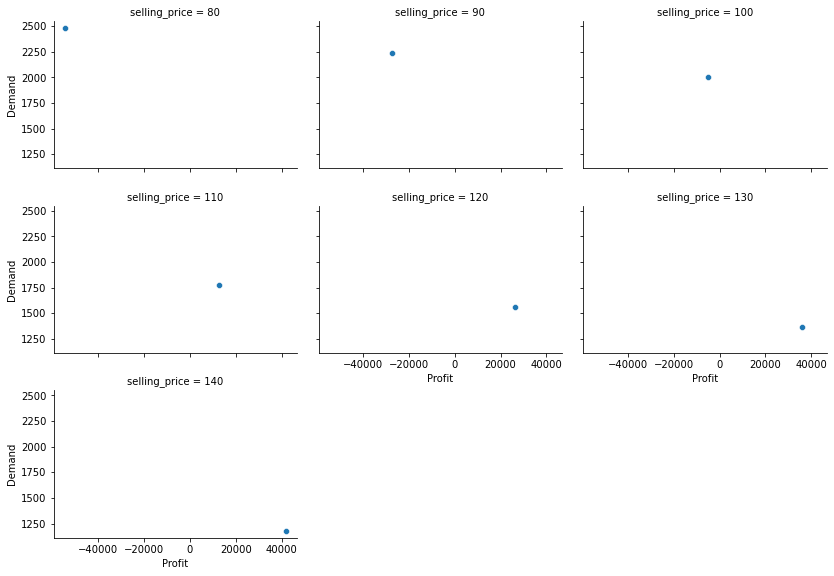

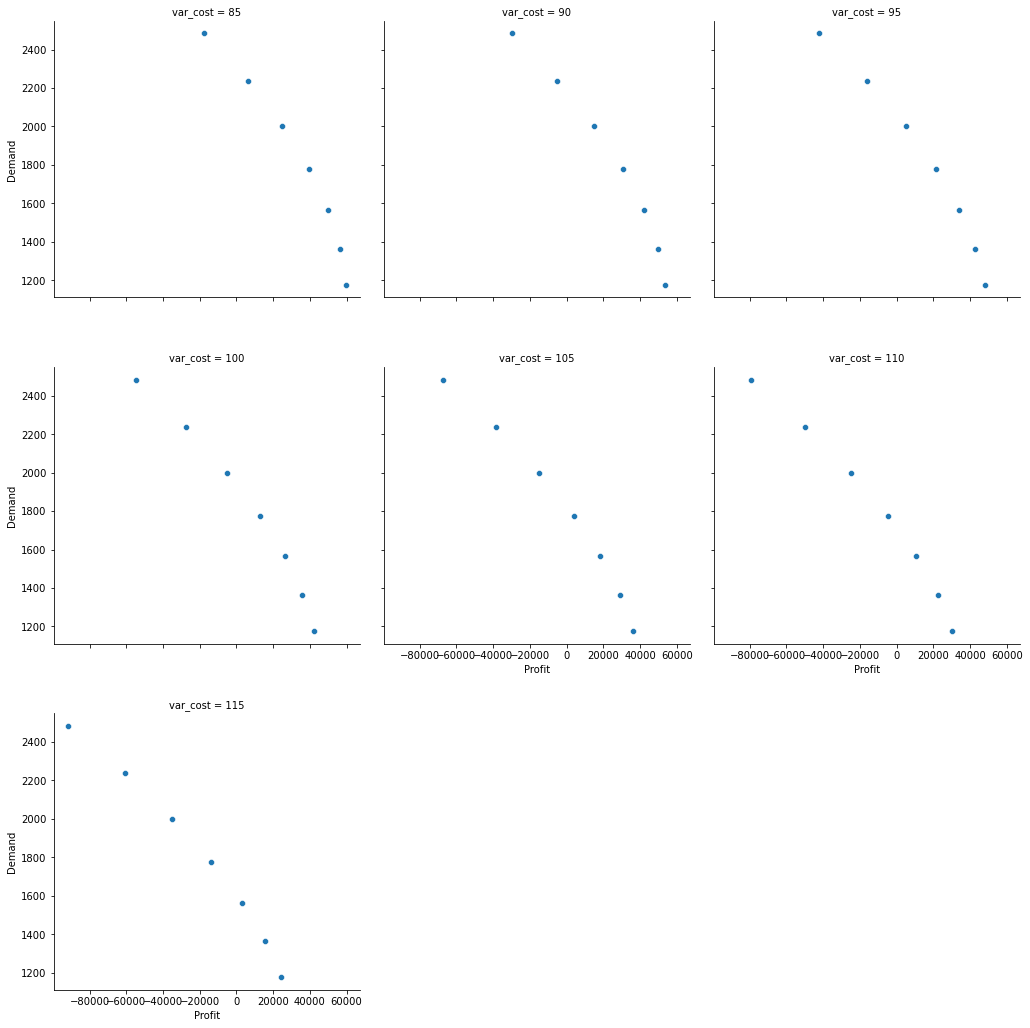

In [163]:
#plot 1-way results using seaborn
g = sns.FacetGrid(m6_dt1_df, col="selling_price", col_wrap=3)
g.map(sns.scatterplot, "profit", "demand")
g.fig.set_size_inches(12, 8)
g.set_axis_labels("Profit", "Demand")
plt.show()

#plot 2-way results using seaborn
g = sns.FacetGrid(m6_dt2_df, col="var_cost", col_wrap=3)
g.map(sns.scatterplot, "profit", "demand")
g.fig.set_size_inches(15, 15)
g.set_axis_labels("Profit", "Demand")
plt.show()

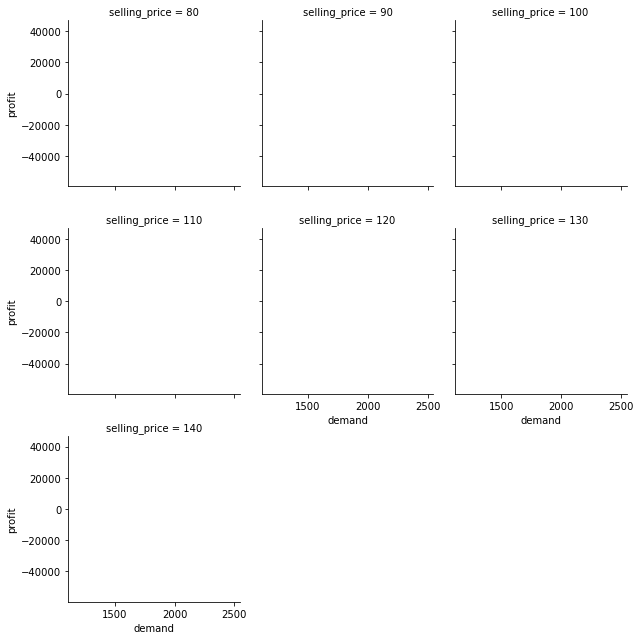

In [164]:
#from notes- this is what I could not correctly replicate
profit_dt_g = sns.FacetGrid(m6_dt1_df, col="selling_price", sharey=True, col_wrap=3)
profit_dt_g = profit_dt_g.map(plt.plot, "demand", "profit")


For some reason, my 1-way data table would not populate line graphs using the code presneted in the notes. I tried a different way.
It appears that the 1-way table between selling price and profit is linear, as selling price increases the demand and profit go down.
This is also echoed by the two way table


### 1c – Goal Seek Break Even

In [165]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection._search import ParameterGrid
import seaborn as sns
import copy

In [166]:
def goal_seek(self, obj_fn, target, by_changing, a, b, N=100):
        """Approximate solution of f(x)=0 on interval [a,b] by bisection method.

        Parameters
        ----------
        obj_fn : str
            The function name for which we are trying to approximate a solution f(x)=target.
        target : float
            The goal
        by_changing : str
            Name of the input variable in model
        a,b : numbers
            The interval in which to search for a solution. The function returns
            None if (f(a) - target) * (f(b) - target) >= 0 since a solution is not guaranteed.
        N : (positive) integer
            The number of iterations to implement.

        Returns
        -------
        x_N : number
            The midpoint of the Nth interval computed by the bisection method. The
            initial interval [a_0,b_0] is given by [a,b]. If f(m_n) - target == 0 for some
            midpoint m_n = (a_n + b_n)/2, then the function returns this solution.
            If all signs of values f(a_n), f(b_n) and f(m_n) are the same at any
            iteration, the bisection method fails and return None.
        """
        # TODO: Checking of inputs and outputs

        # Clone the model
        model_clone = copy.deepcopy(self)

        # The following bisection search is a direct adaptation of
        # https://www.math.ubc.ca/~pwalls/math-python/roots-optimization/bisection/
        # The changes include needing to use an object method instead of a global function
        # and the inclusion of a non-zero target value.

        setattr(model_clone, by_changing, a)
        f_a_0 = getattr(model_clone, obj_fn)()
        setattr(model_clone, by_changing, b)
        f_b_0 = getattr(model_clone, obj_fn)()

        if (f_a_0 - target) * (f_b_0 - target) >= 0:
            # print("Bisection method fails.")
            return None

        # Initialize the end points
        a_n = a
        b_n = b
        for n in range(1, N + 1):
            # Compute the midpoint
            m_n = (a_n + b_n) / 2

            # Function value at midpoint
            setattr(model_clone, by_changing, m_n)
            f_m_n = getattr(model_clone, obj_fn)()

            # Function value at a_n
            setattr(model_clone, by_changing, a_n)
            f_a_n = getattr(model_clone, obj_fn)()

            # Function value at b_n
            setattr(model_clone, by_changing, b_n)
            f_b_n = getattr(model_clone, obj_fn)()

            # Figure out which half the root is in, or if we hit it exactly, or if the search failed
            if (f_a_n - target) * (f_m_n - target) < 0:
                a_n = a_n
                b_n = m_n
            elif (f_b_n - target) * (f_m_n - target) < 0:
                a_n = m_n
                b_n = b_n
            elif f_m_n == target:
                # print("Found exact solution.")
                return m_n
            else:
                # print("Bisection method fails.")
                return None

        # If we get here we hit iteration limit, return best solution found so far
        return (a_n + b_n) / 2

In [167]:
#using goal_Seek from whatif.py
goal_seek(model_6, 'profit', 0, 'selling_price', 80, 140, N=100)

102.57598876953125

Break even selling price is ~$102 

### 1e – Digging deeper

In [168]:
#using goal seek and expanded range
goal_seek(model_6, 'profit', 0, 'selling_price', 80, 250, N=200)

In [169]:
dt_param_ranges_1_2 = {'selling_price': np.arange(80, 260, 10)}

outputs = ['demand', 'profit']

m6_dt1_df_2 = data_table(model_6, dt_param_ranges_1_2, outputs)
m6_dt1_df_2



,selling_price,demand,profit
0,80,2484.0,-54680
1,90,2236.0,-27360
2,100,2000.0,-5000
3,110,1776.0,12760
4,120,1564.0,26280
5,130,1364.0,35920
6,140,1176.0,42040
7,150,1000.0,45000
8,160,836.0,45160
9,170,684.0,42880


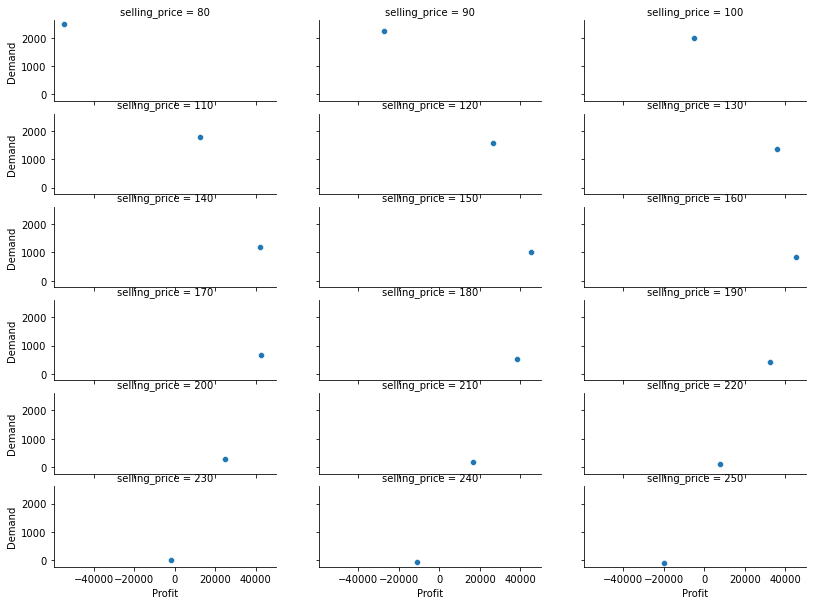

In [170]:
g = sns.FacetGrid(m6_dt1_df_2, col="selling_price", col_wrap=3)
g.map(sns.scatterplot, "profit", "demand")
g.fig.set_size_inches(12, 8)
g.set_axis_labels("Profit", "Demand")
plt.show()

When the range is expanded to selling price 80-250, we see that the lower and upper extremes produce negative profit. Only between selling prices of 110-220 are profits possible

### 1f- Simulation

In [171]:
from numpy.random import default_rng
rg = default_rng(4470)

num_reps = 100
model2 = SingleProductSPF(var_cost=var_cost, 
                        selling_price=selling_price,
                        fixed_cost=fixed_cost,
                        spf_linear=spf_linear,
                        spf_quadratic=spf_quadratic,
                        spf_constant=spf_constant)

random_inputs = {'var_cost': rg.uniform(80, 120, num_reps)}

In [172]:
scenario_inputs = {'var_cost': np.arange(80, 130, 10)}
list(ParameterGrid(scenario_inputs))

[{'var_cost': 80},
 {'var_cost': 90},
 {'var_cost': 100},
 {'var_cost': 110},
 {'var_cost': 120}]

In [173]:
sim_outputs = ['profit']

In [174]:
def simulate(self, random_inputs, outputs, scenario_inputs=None, keep_random_inputs=False):
        """Simulate model for one or more scenarios

        Parameters
        ----------
        random_inputs : dict of str to sequence of random variates
            Keys are stochastic input variable names and values are sequence of $n$ random variates, where $n$ is the number of simulation replications
        outputs : list of str
            List of output variable names
        scenario_inputs : optional (default is None), dict of str to sequence
            Keys are deterministic input variable names and values are sequence of values for each scenario for this variable. Is consumed by
            scikit-learn ParameterGrid() function. See https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html
        keep_random_inputs : optional (default is False), boolean
            If True, all the random input variates are included in the results dataframe

        Returns
        -------
        results : list of dictionaries
            Values of all outputs for each simulation replication. If `scenario_inputs` is not None,
            then there is one dictionary for each combination of scenario inputs, otherwise, there
            is a single dictionary.

            Keys of results list:

            scenario_base_vals -- values of model object attributes
            scenario_num -- int starting at 1
            scenario_vals -- {} if `scenario_inputs` is None, else scenario specific values
            output -- dictionary of `np.array` objects whose keys are the elements of `outputs`
            
        Notes
        -----
        Perhaps add a model assumptions related attribute and associated methods
        """

        # Clone the model
        model_clone = copy.deepcopy(self)

        # Update clone with random_inputs
        model_clone.update(random_inputs)

        # Store raw simulation input values if desired
        if keep_random_inputs:
            scenario_base_vals = vars(model_clone)
        else:
            scenario_base_vals = vars(self)

        # Initialize output counters and containers
        scenario_num = 0
        scenario_results = []

        # Check if multiple scenarios
        if scenario_inputs is not None:
            # Create parameter grid for scenario inputs
            sim_param_grid = list(create_parameter_grid(scenario_inputs))

            # Scenario loop
            for params in sim_param_grid:
                model_clone.update(params)
                # Initialize scenario related outputs
                result = {}
                scenario_vals = copy.copy(params)
                result['scenario_base_vals'] = scenario_base_vals
                result['scenario_num'] = scenario_num
                result['scenario_vals'] = scenario_vals
                raw_output = {}

                # Output measure loop
                for output_name in outputs:
                    output_array = getattr(model_clone, output_name)()
                    raw_output[output_name] = output_array

                # Gather results for this scenario
                result['output'] = raw_output
                scenario_results.append(result)
                scenario_num += 1

            return scenario_results

        else:
            # Similar logic to above, but only a single scenario
            results = []
            result = {}

            result['scenario_base_vals'] = scenario_base_vals
            result['scenario_num'] = scenario_num
            result['scenario_vals'] = {}

            raw_output = {}
            for output_name in outputs:
                output_array = getattr(model_clone, output_name)()
                raw_output[output_name] = output_array

            result['output'] = raw_output
            results.append(result)

            return results

In [175]:
model2_results = simulate(model2, random_inputs, sim_outputs, scenario_inputs)

In [176]:
def get_sim_results_df(results):
    
    dfs = []    
    for r in results:
        df = pd.DataFrame(r['output'])
        df['scenario_num'] = r['scenario_num']
        for key, val in r['scenario_vals'].items():
            df[key] = val
            
        dfs.append(df)

    results_df = pd.concat(dfs)
    
    return results_df

In [177]:
which_scenario = 4

# What are the keys in the output dictionaries
model2_results[which_scenario].keys()

dict_keys(['scenario_base_vals', 'scenario_num', 'scenario_vals', 'output'])

In [178]:
model2_results[which_scenario]['scenario_vals']

{'var_cost': 120}

In [179]:
for scenario in model2_results:
    print(scenario['scenario_num'], scenario['scenario_vals'], scenario['output']['profit'])

0 {'var_cost': 80} 53398
1 {'var_cost': 90} 36712
2 {'var_cost': 100} 20028
3 {'var_cost': 110} 3342
4 {'var_cost': 120} -13342


In [180]:
model2_results[4]

{'scenario_base_vals': {'var_cost': 100,
  'selling_price': 115,
  'fixed_cost': 5000,
  'spf_linear': -35,
  'spf_constant': 4900,
  'spf_quadratic': 0.06},
 'scenario_num': 4,
 'scenario_vals': {'var_cost': 120},
 'output': {'profit': -13342}}

In [181]:
def get_sim_results_df(results):
    """Transform raw simulation output dictionary to Pandas ``DataFrame``.

    Parameters
    ----------
    results : list of dictionaries

    Returns
    -------
    Pandas DataFrame
    """
    dfs = []
    for r in results:
        df = pd.DataFrame(r['output'])
        df['scenario_num'] = r['scenario_num']
        for key, val in r['scenario_vals'].items():
            df[key] = val

        dfs.append(df)

    if len(dfs) > 1:
        results_df = pd.concat(dfs)
        return results_df
    else:
        return dfs[0]

In [182]:
model2_results_df = get_sim_results_df(model2_results)

ValueError: If using all scalar values, you must pass an index

Although I was unable to create the dataframe to plot the results, based on our simulation it is a low probability that the profit will be negative between variable cost of 80-120 based on the scaenario of model_2 results